# Problem Description

This notebook will guide you through implementation of **multivariate linear regression** to to solve the **polynomial regression** problem:

$$
h_{\theta}(x) = \theta_0 + \theta_1 x + \theta_2 x^2 +  \theta_3 x^3 + \theta_4 x^4
= \boldsymbol{\theta}^T \mathbf{x}
$$

$$
\boldsymbol{\theta} = \begin{bmatrix}\theta_0 \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4\end{bmatrix},
\qquad
\mathbf{x} = \begin{bmatrix}1 \\ x \\ x^2 \\ x^3 \\ x^4\end{bmatrix}
$$

Below, you will follow steps to

1. Implement the cost function for multivarate linear regression
1. Compare vectorized code with for-loops
1. Implement the normal equations method to solve a multivariate linear regression problem
1. Implement gradient descent for multivariate linear regression
1. Experiment with feature normalization to improve the convergence of gradient descent


## Imports
Run this code.

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Helper functions
Run this code to set up the helper functions. The function ``feature_expansion`` accepts an vector of $n$ scalar x values and returns an $n \times 5$ data matrix by applying the feature expansion $x \mapsto [1, x, x^2, x^3, x^4]$ to each scalar $x$ value.

In [153]:
def feature_expansion(x, deg):
    if x.ndim > 1:
        raise ValueError('x should be a 1-dimensional array')
    m = x.shape
    x_powers = [x**k for k in range(0,deg+1)]
    X = np.stack( x_powers, axis=1 )

    return X

def plot_model(X_test, theta):
    '''
    Note: uses globals x, y, x_test, which are assigned below
    when the dataset is created. Don't overwrite these variables.
    '''
    y_test = np.dot(X_test, theta)
    plt.scatter(x, y)
    plt.plot(x_test, y_test)
    plt.legend(['Test', 'Train'])
    plt.show()

## (Question) List comprehensions

Read about Python list comprehensions. Explain what is happening in the following line of code

```python
x_powers = [x**k for k in range(0,deg+1)]
```

** *Your answer here* **

Python's list comprehension is used to generate a list x_powers which contains values of x raised to the powers from 0 to deg.

## Create a data set for polynomial regression

Read and run the code below. This generates data from a fourth-degree polynomial and then uses feature expansion to set up the problem of learning the polynomial as multivariate linear regression

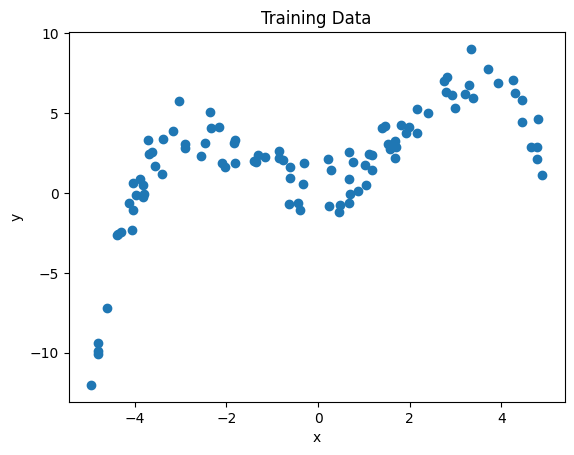

In [154]:
# Set random seed
np.random.seed(0)

# Create random set of m training x values between -5 and 5
m = 100
x = np.random.rand(m)*10 - 5

# Create evenly spaced test x values (for plotting)
x_test  = np.linspace(-5, 5, 100)
m_test  = len(x_test);

# Feature expansion for training and test x values
deg = 4
X      = feature_expansion(x, deg)
X_test = feature_expansion(x_test, deg)

n = deg + 1   # total number of features including the '1' feature

# Define parameters (theta) and generate y values
theta = 0.1*np.array([1, 1, 10, 0.5, -0.5]);
y = np.dot(X, theta) + np.random.randn(m)   # polynomial plus noise

# Plot the training data
plt.scatter(x, y)
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [155]:
#look at the feature expansion for a single training example
print(x[0]) #original data
print(X[0]) #data with feature expansion

0.48813503927324753
[1.         0.48813504 0.23827582 0.11631078 0.05677536]


## Implement the cost function
Follow the instructions to implement the following cost function for multivariate linear regression:

$$J(\theta) = \frac{1}{2}\sum_{i=1}^n(h_{\theta}(x^{(i)})-y^{(i)})^2$$

### (Question)  Cost function with loops
First, implement the cost function using a for-loops: `cost_function_loops`.

In [156]:
def cost_function_loops(X, y, theta):
    '''
    Compute the cost function for a particular data set and hypothesis (parameter vector)

    Inputs:
        X       m x n data matrix
        y       training output (length m vector)
        theta   parameters (length n vector)
    Output:
        cost    the value of the cost function (scalar)
    '''
    m = len(y)
    cost = 0

    for i in range(m):
        h = np.dot(theta, X[i])
        cost += (h - y[i])**2

    cost = 0.5 * cost
    return cost

### (Question)  Vectorized cost function
Now, implment the same cost function but now WITHOUT any for-loops. You should be using NumPy. This is a "vectorized" version of the cost function: `cost_function_vec`

In [157]:
def cost_function_vec(X, y, theta):
    '''
    Vectorized version of the cost function for a particular data set and hypothesis

    Inputs:
        X       m x n data matrix
        y       training output (length m vector)
        theta   parameters (length n vector)
    Output:
        cost    the value of the cost function (scalar)
    '''
    m = len(y)

    # Compute hypothesis h = X * theta
    h = np.dot(X, theta)

    # Compute squared error
    squared_error = np.sum((h - y)**2)

    # Compute cost function J(theta)
    cost = squared_error / 2

    return cost

## Test the cost function
Run this to test your cost function.

In [158]:
np.random.seed(1)

theta_random = np.random.rand(n)
theta_zeros  = np.zeros(n)
theta_ones   = np.ones(n)

print("cost_function_loops")
print("=="*10)
print( "Cost (random): %.2f" % cost_function_loops(X, y, theta_random))  # prints 54523.64
print( "Cost (zeros): %.2f" % cost_function_loops(X, y, theta_zeros))   # prints 845.65
print( "Cost (ones): %.2f" % cost_function_loops(X, y, theta_ones))    # prints 2524681.08
print()
print("cost_function_vec")
print("=="*10)
print( "Cost (random): %.2f" % cost_function_vec(X, y, theta_random))  # prints 54523.64
print( "Cost (zeros): %.2f" % cost_function_vec(X, y, theta_zeros))   # prints 845.65
print( "Cost (ones): %.2f" % cost_function_vec(X, y, theta_ones))    # prints 2524681.08
print()
#Note: The for-loop and vectorized cost function implementations should return the EXACT
# same results.

cost_function_loops
Cost (random): 54523.64
Cost (zeros): 845.65
Cost (ones): 2524681.08

cost_function_vec
Cost (random): 54523.64
Cost (zeros): 845.65
Cost (ones): 2524681.08



## (Question)  Time cost functions

- Run `cost_function_loops` and `cost_function_vec` each 100 times for `theta_random` and the `X` and `y` given above
- Print out the mean and standard deviation across all runs for each function
- Report which function is faster.  

In [159]:
np.random.seed(1)
theta_random = np.random.rand(n)
##################
# TODO: implement your code here #
##################
loops_costs = []
vec_costs = []
vec_times=[]
loops_times=[]
import time
# Run cost_function_loops
for _ in range(100):
    start_time = time.time()
    cost = cost_function_loops(X, y, theta_random)
    loops_times.append(time.time() - start_time)
    loops_costs.append(cost)

# Run cost_function_vec
for _ in range(100):
    start_time = time.time()
    cost=cost_function_vec(X, y, theta_random)
    vec_times.append(time.time() - start_time)
    vec_costs.append(cost)

# Calculate mean and standard deviation of costs
loops_mean = np.mean(loops_costs)
loops_std = np.std(loops_costs)
vec_mean = np.mean(vec_costs)
vec_std = np.std(vec_costs)

# Print results
print("cost_function_loops:")
print(f"  Mean cost: {loops_mean:.6f}")
print(f"  Standard deviation of cost: {loops_std:.6f}")

print("\ncost_function_vec:")
print(f"  Mean cost: {vec_mean:.6f}")
print(f"  Standard deviation of cost: {vec_std:.6f}")

# Calculate mean and standard deviation
loops_mean = np.mean(loops_times)
vec_mean = np.mean(vec_times)


# Compare which function is faster
if loops_mean < vec_mean:
    print("\ncost_function_loops is faster.")
else:
    print("\ncost_function_vec is faster.")

cost_function_loops:
  Mean cost: 54523.642770
  Standard deviation of cost: 0.000000

cost_function_vec:
  Mean cost: 54523.642770
  Standard deviation of cost: 0.000000

cost_function_vec is faster.


** *Write answer here: report which function is faster* **


cost_function_vec is faster indicating that the vectorized implementation outperforms the loop-based implementation (cost_function_loops) in terms of computational efficiency.


### For the rest of this notebook, we will use the vectorized implementation of the cost function
Run the code below.

In [160]:
cost_function = cost_function_vec

In [161]:
#make sure it works
cost_function(X, y, theta_random)

54523.642769664846

## (Question) Implement first training algorithm: normal equations
Implement a *vectorized* version of the normal equations! If you use for-loops you will not get full credit.

In [163]:
def normal_equations(X, y):
    '''
    Train a linear regression model using the normal equations

    Inputs:
        X       m x n data matrix
        y       training output (length m vector)
    Output:
        theta   parameters (length n vector)
    '''
    # Calculate theta using the normal equation
    theta = np.linalg.inv(X.T @ X) @ X.T @ y

    return theta

## Use normal equations to fit the model
Run this code to test your implementation of the normal equations. If it runs properly you will see a curve that fits the data well. Note the value of the cost function for ``theta_normal_equations``.

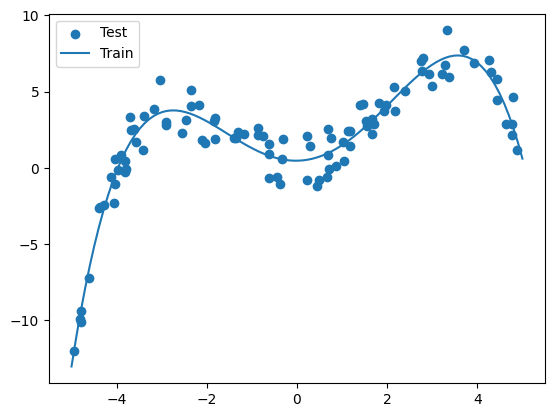

Cost function: 48.54


In [164]:
theta_normal_equations = normal_equations(X, y)
plot_model(X_test, theta_normal_equations)
print ("Cost function: %.2f" % cost_function(X, y, theta_normal_equations))

## (Question) Implement second training algorithm: (vectorized) gradient descent

Implement gradient descent for multivariate linear regression. Make sure your solution is vectorized. If you use for-loops to compute the gradient you will not receive full credit.

In [165]:
def gradient_descent(X, y, alpha, iters, theta=None):
    m, n = X.shape

    if theta is None:
        theta = np.zeros(n)

    J_history = np.zeros(iters)

    for i in range(iters):
        h = np.dot(X, theta)
        error = h - y
        gradient = (1 / m) * np.dot(X.T, error)
        theta = theta - alpha * gradient

        # Record the cost function
        J_history[i] = cost_function(X, y, theta)

    return theta, J_history

## (Question) Use gradient descent to train the model
* Write code to call your ``gradient_descent`` method to learn parameter
* Plot the model fit (use ``plot_model``)
* Plot the cost function vs. iteration to help assess convergence
* Print the final value of the cost function
* Experiment with different step sizes and numbers of iterations until you can find a good hypothesis. Try to match the cost function value from ``normal_equations`` to two decimal places. How many iterations does this take?

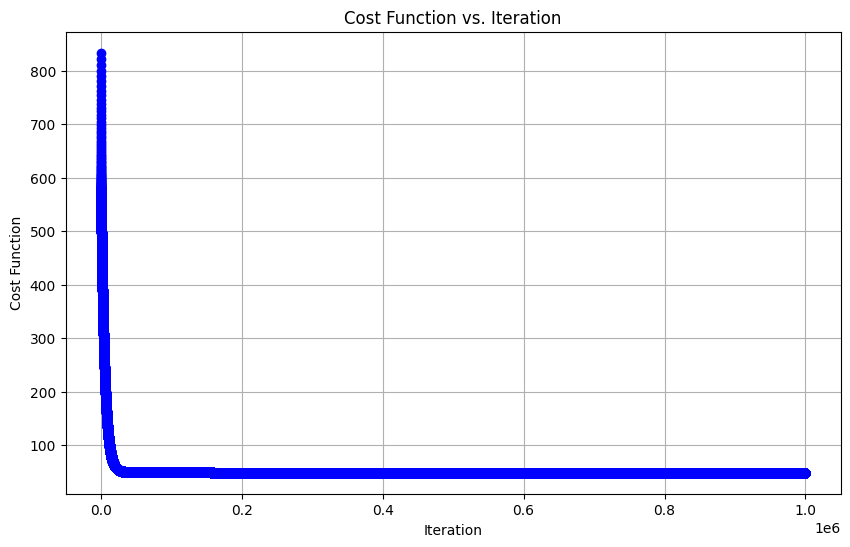

Final Cost Function Value: 48.54


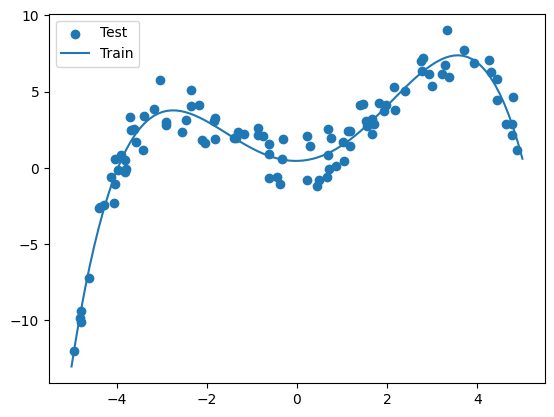

In [176]:
def train_with_gradient_descent(X, y, alpha, iters):

    # Initialize theta and run gradient descent
    theta_initial = np.zeros(X.shape[1])
    theta_learned, J_history = gradient_descent(X, y, alpha, iters, theta_initial)

    # Plot cost function vs. iteration
    plt.figure(figsize=(10, 6))
    plt.plot(range(iters), J_history, marker='o', color='b', linestyle='-', linewidth=2)
    plt.title('Cost Function vs. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost Function')
    plt.grid(True)
    plt.show()

    # Print final cost function value
    final_cost = cost_function(X, y, theta_learned)
    print(f'Final Cost Function Value: {final_cost:.2f}')

    return theta_learned

# Experiment with different alpha and iters to find a good hypothesis
alpha = 0.00001
iters = 1000000

# Train the model and visualize results
theta_learned = train_with_gradient_descent(X, y, alpha, iters)


# Plot the model fit
plot_model(X_test, theta_learned)

## (Question) Gradient descent with feature normalization
You should have observed
that it takes many iterations of gradient descent to match the cost
function value achieved by the normal equations. Now
you will implement feature normalization to improve the convergence
of gradient descent. Remember that the formula
for feature normalization is:

$$x^{(i)}_j \leftarrow \frac{x^{(i)}_j - \mu_j}{\sigma_j}$$

Here are some guidelines for the implementation:

* The same transformation should be applied to train and test data.

* The values $\mu_j$ and $\sigma_j$ are the mean and standard deviation of
the $j$th column (i.e., feature) in the **training data**. (Hint:
there are numpy functions to compute these.)

* Do not normalize the column of all ones. (Optional question: why?)

* Use broadcasting to do the normalization--don't write for loops

After normalizing both the training data and test data, follow the same steps as above to experiment with gradient descent using the *normalized* training and test data: print the value of the cost function, and create the same plots. Tune the step size and number of iterations again to make gradient descent converge as quickly as possible. How many iterations does it take to match the cost function value from ``normal_equations`` to two decimal places?  


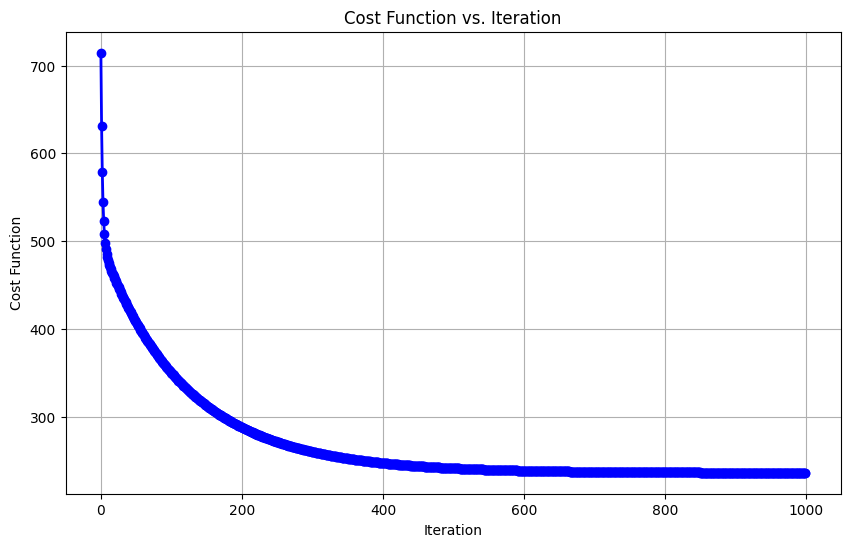

Final Cost Function Value: 236.46


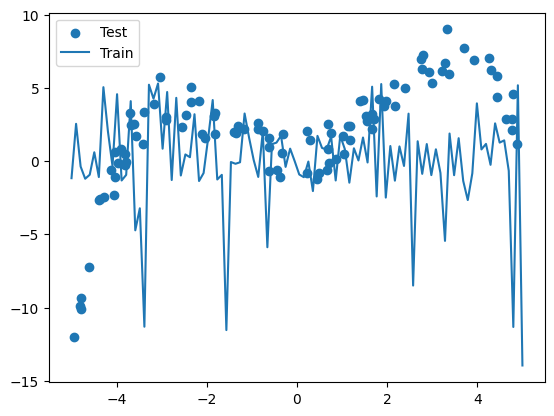

In [244]:
# TODO: your code for gradient descent with feature normalization
def compute_mean_std(X):
    """Compute mean and standard deviation for each feature column in X."""
    mu = np.mean(X, axis=0, keepdims=True)  # Compute mean along axis 0 (columns), keeping dimensions
    sigma = np.std(X, axis=0, keepdims=True)  # Compute standard deviation along axis 0 (columns), keeping dimensions
    return mu, sigma

def normalize_features(X, mu, sigma):
    """Normalize each feature column of X using broadcasting."""
    epsilon = 1e-8  # Small epsilon to avoid division by zero
    normalized_X = (X - mu) / (sigma + epsilon)
    return normalized_X

mu, sigma = compute_mean_std(X[:, 1:])  # Exclude the first column (intercept column) from normalization
X_test_norm = normalize_features(X[:, 1:], mu, sigma)


alpha = 0.1
iters = 1000
theta_learned = train_with_gradient_descent(X_test_norm, y, alpha, iters)
plot_model(X_test_norm,theta_learned)

** *Write answer here: how many iterations?* **